In [52]:
%pip install numpy pandas scipy matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [53]:
# Cell 2: Imports
import numpy as np
import pandas as pd
import json
from scipy import stats
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## Reading results from the json file 
* Reading all the data from the json file which have list of information generated for each person by different models
* Each item of the list will have the model details, responses from the LLM, final trust-distrust list for 100  runs and the final trust & distrust estimates probability distribution 

In [54]:
data = json.load(open('/Users/appikatlaanudeep/Documents/projects/quant-cognitive-bias-llm/Muralicode/results.json'))

In [55]:
len(data)

435

In [56]:
data[0]["metadata"]

{'name': 'llama3.2:latest',
 'ollama_config': {'temperature': 0.7},
 'transformer_model_config': None,
 'enterprise_model_config': None}

In [57]:
unique_names = set(d['metadata']['name'] for d in data)
print(unique_names)


{'phi4:latest', 'mistral:latest', 'qwen2.5:32b', 'gemma3:27b', 'llama3.2:latest'}


## Seperating the data based on the model

In [58]:
llama_data = [d for d in data if d['metadata']['name'] == "llama3.2:latest"]
mistral_data = [d for d in data if d['metadata']['name'] == "mistral:latest"]
phi_data = [d for d in data if d['metadata']['name'] == "phi4:latest"]
qwen_data = [d for d in data if d['metadata']['name'] == "qwen2.5:32b"]
gemma_data = [d for d in data if d['metadata']['name'] == "gemma3:27b"]

## Seperating the neutral case for future use of prompt based bias removal & comparisons 

In [59]:
def get_neutral_distributions(model_data):
    """
    Get trust and distrust probability distributions from neutral persona data
    
    Args:
        model_data (list): List of model data dictionaries
        
    Returns:
        tuple: (trust_probability, distrust_probability)
    """
    neutral_data = next(d for d in model_data if d['persona'] == "neutral")
    return {
        "trust_estimate_probability_distribution": neutral_data["trust_estimate_probability_distribution"], 
        "distrust_estimate_probability_distribution": neutral_data["distrust_estimate_probability_distribution"]
    }

# Example usage:
mistral_neutral_data= get_neutral_distributions(mistral_data)
llama_neutral_data= get_neutral_distributions(llama_data)
phi_neutral_data= get_neutral_distributions(phi_data)
qwen_neutral_data= get_neutral_distributions(qwen_data)
gemma_neutral_data= get_neutral_distributions(gemma_data)

(mistral_neutral_data, llama_neutral_data, phi_neutral_data, qwen_neutral_data, gemma_neutral_data)


({'trust_estimate_probability_distribution': 0.81,
  'distrust_estimate_probability_distribution': 0.19},
 {'trust_estimate_probability_distribution': 0.23,
  'distrust_estimate_probability_distribution': 0.77},
 {'trust_estimate_probability_distribution': 0.09,
  'distrust_estimate_probability_distribution': 0.91},
 {'trust_estimate_probability_distribution': 1.0,
  'distrust_estimate_probability_distribution': 0.0},
 {'trust_estimate_probability_distribution': 0.0,
  'distrust_estimate_probability_distribution': 1.0})

## Chi Square test for hypthesis validation 

* **Hypothesis** - The probability estimates of trust and distrust will remain same in both neutral case and in case with persona attached to the partner
* We use Chi-Square Significance test for checking if the data generated is drifting far from the neutral case
* We use a significance level of 95% for this
* We use the neutral case trust & distruct estimates as expected values while using the persona case data as the observed
* This will leave us with a degrees of freedom of 2

In [60]:
from scipy.stats import chisquare


def compare_trust_distributions(model_data, neutral_data, significance_level=0.05):
    """
    Compare trust/distrust distributions against neutral case using chi-square test
    """
    # Extract trust/distrust values
    model_trust = model_data["trust_estimate_probability_distribution"] if model_data["trust_estimate_probability_distribution"] != 0 else 0.00000001
    model_distrust = model_data["distrust_estimate_probability_distribution"] if model_data["distrust_estimate_probability_distribution"] != 0 else 0.00000001
    neutral_trust = neutral_data["trust_estimate_probability_distribution"] if neutral_data["trust_estimate_probability_distribution"] != 0 else 0.00000001
    neutral_distrust = neutral_data["distrust_estimate_probability_distribution"] if neutral_data["distrust_estimate_probability_distribution"] != 0 else 0.00000001
    
    # Create contingency table with observed (model) and expected (neutral) values
    observed = [model_trust, model_distrust]
    expected = [neutral_trust, neutral_distrust]
    
    # Convert probabilities to counts by multiplying by total runs
    total_runs = model_data["total_runs"]
    observed_counts = [x * total_runs for x in observed]
    expected_counts = [x * total_runs for x in expected]
    
    # Perform chi-square test comparing observed against expected
    chi2, p_value = chisquare(observed_counts, expected_counts)
    dof = 1  # Degrees of freedom for 2 categories

    # Determine if the difference is statistically significant
    is_significant = p_value < significance_level

    if not is_significant:
        print(f"The difference is not statistically significant (p >= {significance_level}), persona: {model_data['persona']}")
    
    return {
        'chi2': float(chi2),
        'p_value': float(p_value),
        'dof': int(dof),
        "is_significant": bool(is_significant),
        'expected': expected,
        'observed': observed
    }

In [61]:
def compare_model_data(model_data, neutral_data):
    """
    Compare model data against neutral case for all personas
    """
    results = []
    for data in model_data:
        if data['persona'] != 'neutral':
            result = compare_trust_distributions(data, neutral_data)
            result['persona'] = data['persona']
            result['gender'] = data['gender']
            result['race'] = data['race']
            result['ethnicity'] = data['ethnicity']
            result['trust_estimate_probability_distribution'] = data["trust_estimate_probability_distribution"]
            result['distrust_estimate_probability_distribution'] = data["distrust_estimate_probability_distribution"]
            results.append(result)
    return results

# Compare data for all models
mistral_results = compare_model_data(mistral_data, mistral_neutral_data)
llama_results = compare_model_data(llama_data, llama_neutral_data)
phi_results = compare_model_data(phi_data, phi_neutral_data)
qwen_results = compare_model_data(qwen_data, qwen_neutral_data)
gemma_results = compare_model_data(gemma_data, gemma_neutral_data)

# Print results
print("Mistral Results:")
for result in mistral_results:
    print(f"\nPersona: {result['persona']}")
    print(f"Chi-square: {result['chi2']:.4f}")
    print(f"p-value: {result['p_value']:.4f}")
    print(f"Degrees of freedom: {result['dof']}")
    print(f"Expected: {result['expected']}")
    print(f"Observed: {result['observed']}")

print("\nLlama Results:")
for result in llama_results:
    print(f"\nPersona: {result['persona']}")
    print(f"Chi-square: {result['chi2']:.4f}")
    print(f"p-value: {result['p_value']:.4f}")
    print(f"Degrees of freedom: {result['dof']}")


The difference is not statistically significant (p >= 0.05), persona: gender is female
The difference is not statistically significant (p >= 0.05), persona: gender is male, race is caucasian
The difference is not statistically significant (p >= 0.05), persona: gender is male, ethnicity is asian
The difference is not statistically significant (p >= 0.05), persona: gender is male, race is caucasian, ethnicity is asian
The difference is not statistically significant (p >= 0.05), persona: gender is male, race is caucasian, ethnicity is asian
The difference is not statistically significant (p >= 0.05), persona: gender is female, race is caucasian, ethnicity is hispanic
The difference is not statistically significant (p >= 0.05), persona: gender is male, race is caucasian, ethnicity is hispanic
The difference is not statistically significant (p >= 0.05), persona: gender is male, race is caucasian, ethnicity is hispanic
The difference is not statistically significant (p >= 0.05), persona: gen

## Removing the prompt influenced bias by checking how much the trust & distruct estimates differ from the neutral condition


In [62]:
def calculate_trust_deltas(results, model_name):
    """
    Calculate trust and distrust deltas for a given model's results
    
    Args:
        results: List of result dictionaries for a model
        model_name: Name of the model for printing
        
    Returns:
        List of results with added trust_delta and distrust_delta fields
    """
    print(f"\n{model_name} Trust/Distrust Deltas:")
    for result in results:
        trust_delta = result['observed'][0] - result['expected'][0]
        distrust_delta = result['observed'][1] - result['expected'][1]
        result['trust_delta'] = trust_delta
        result['distrust_delta'] = distrust_delta
        print(f"\nPersona: {result['persona']}")
        print(f"Trust Delta: {trust_delta:.4f}")
        print(f"Distrust Delta: {distrust_delta:.4f}")
    return results

# Calculate deltas for all models
mistral_results = calculate_trust_deltas(mistral_results, "Mistral")
llama_results = calculate_trust_deltas(llama_results, "Llama")
phi_results = calculate_trust_deltas(phi_results, "Phi")
qwen_results = calculate_trust_deltas(qwen_results, "Qwen")
gemma_results = calculate_trust_deltas(gemma_results, "Gemma")



Mistral Trust/Distrust Deltas:

Persona: gender is female, race is caucasian
Trust Delta: 0.1600
Distrust Delta: -0.1600

Persona: gender is female, race is caucasian
Trust Delta: 0.1500
Distrust Delta: -0.1500

Persona: gender is female, race is caucasian, ethnicity is hispanic
Trust Delta: 0.1700
Distrust Delta: -0.1700

Persona: gender is male, race is caucasian, ethnicity is hispanic
Trust Delta: 0.1400
Distrust Delta: -0.1400

Persona: gender is male, race is caucasian, ethnicity is hispanic
Trust Delta: 0.1400
Distrust Delta: -0.1400

Persona: gender is male, race is black
Trust Delta: 0.1700
Distrust Delta: -0.1700

Persona: gender is female, ethnicity is hispanic
Trust Delta: 0.1900
Distrust Delta: -0.1900

Persona: race is caucasian
Trust Delta: 0.1900
Distrust Delta: -0.1900

Persona: gender is female, race is caucasian
Trust Delta: 0.1800
Distrust Delta: -0.1800

Persona: gender is female
Trust Delta: 0.0000
Distrust Delta: 0.0000

Persona: gender is female, race is caucasi

In [63]:
mistral_results[0]

{'chi2': 16.63417803768681,
 'p_value': 4.532682509811189e-05,
 'dof': 1,
 'is_significant': True,
 'expected': [0.81, 0.19],
 'observed': [0.97, 0.03],
 'persona': 'gender is female, race is caucasian',
 'gender': 'female',
 'race': 'caucasian',
 'ethnicity': None,
 'trust_estimate_probability_distribution': 0.97,
 'distrust_estimate_probability_distribution': 0.03,
 'trust_delta': 0.15999999999999992,
 'distrust_delta': -0.16}

## Normalizing the difference found above , but in ourcase we already are normalizing at the initial value generation of estimate so we need not do this 

In [64]:
def calculate_relative_normalized_bias(results, model_name):
    """
    Calculate relative normalized bias for a given model's results
    
    Args:
        results: List of result dictionaries for a model
        model_name: Name of the model for printing
        
    Returns:
        List of results with added trust_bias and distrust_bias fields
    """
    print(f"\n{model_name} Relative Normalized Bias:")
    for result in results:
        trust_bias = result['trust_delta']
        distrust_bias = result['distrust_delta']
        result['trust_bias'] = trust_bias
        result['distrust_bias'] = distrust_bias
        print(f"\nPersona: {result['persona']}")
        print(f"Trust Bias: {trust_bias:.4f}")
        print(f"Distrust Bias: {distrust_bias:.4f}")
    return results

# Calculate relative normalized bias for all models
mistral_results = calculate_relative_normalized_bias(mistral_results, "Mistral")
llama_results = calculate_relative_normalized_bias(llama_results, "Llama")
phi_results = calculate_relative_normalized_bias(phi_results, "Phi")
qwen_results = calculate_relative_normalized_bias(qwen_results, "Qwen")
gemma_results = calculate_relative_normalized_bias(gemma_results, "Gemma")



Mistral Relative Normalized Bias:

Persona: gender is female, race is caucasian
Trust Bias: 0.1600
Distrust Bias: -0.1600

Persona: gender is female, race is caucasian
Trust Bias: 0.1500
Distrust Bias: -0.1500

Persona: gender is female, race is caucasian, ethnicity is hispanic
Trust Bias: 0.1700
Distrust Bias: -0.1700

Persona: gender is male, race is caucasian, ethnicity is hispanic
Trust Bias: 0.1400
Distrust Bias: -0.1400

Persona: gender is male, race is caucasian, ethnicity is hispanic
Trust Bias: 0.1400
Distrust Bias: -0.1400

Persona: gender is male, race is black
Trust Bias: 0.1700
Distrust Bias: -0.1700

Persona: gender is female, ethnicity is hispanic
Trust Bias: 0.1900
Distrust Bias: -0.1900

Persona: race is caucasian
Trust Bias: 0.1900
Distrust Bias: -0.1900

Persona: gender is female, race is caucasian
Trust Bias: 0.1800
Distrust Bias: -0.1800

Persona: gender is female
Trust Bias: 0.0000
Distrust Bias: 0.0000

Persona: gender is female, race is caucasian, ethnicity is 

In [65]:
mistral_results[0]

{'chi2': 16.63417803768681,
 'p_value': 4.532682509811189e-05,
 'dof': 1,
 'is_significant': True,
 'expected': [0.81, 0.19],
 'observed': [0.97, 0.03],
 'persona': 'gender is female, race is caucasian',
 'gender': 'female',
 'race': 'caucasian',
 'ethnicity': None,
 'trust_estimate_probability_distribution': 0.97,
 'distrust_estimate_probability_distribution': 0.03,
 'trust_delta': 0.15999999999999992,
 'distrust_delta': -0.16,
 'trust_bias': 0.15999999999999992,
 'distrust_bias': -0.16}

## Getting the contribution or effect of single category by getting an average of trust & distrust estimates from those data which only have those categorie. These will be further used in future for the calculation of attribution

In [66]:
def get_category_contributions(results):
    """
    Calculate the contributions of each category to the trust and distrust bias. Here we are calculating the basic indivuidual bias contributions.
    """
    category_contributions = {
        "gender": {
            "trust_bias": [],
            "distrust_bias": []
        },
        "race": {
            "trust_bias": [],
            "distrust_bias": [] 
        },
        "ethnicity": {
            "trust_bias": [],
            "distrust_bias": []
        }
    }

    for result in results:
        if result['gender'] is None and result['race'] is None and result['ethnicity'] is not None:
            category_contributions['ethnicity']['trust_bias'].append(result['trust_estimate_probability_distribution'])
            category_contributions['ethnicity']['distrust_bias'].append(result['distrust_estimate_probability_distribution'])
            # print(category_contributions['ethnicity'])
        elif result['gender'] is None and result['race'] is not None and result['ethnicity'] is None:
            category_contributions['race']['trust_bias'].append(result['trust_estimate_probability_distribution'])
            category_contributions['race']['distrust_bias'].append(result['distrust_estimate_probability_distribution'])
            # print(category_contributions['race'])
        elif result['gender'] is not None and result['race'] is None and result['ethnicity'] is None:
            category_contributions['gender']['trust_bias'].append(result['trust_estimate_probability_distribution'])
            category_contributions['gender']['distrust_bias'].append(result['distrust_estimate_probability_distribution'])
            # print("Gender", category_contributions['gender'])

    # Calculate averages
    category_averages = {
        'gender': {
            'trust_bias': sum(category_contributions['gender']['trust_bias']) / len(category_contributions['gender']['trust_bias']) if category_contributions['gender']['trust_bias'] else 0,
            'distrust_bias': sum(category_contributions['gender']['distrust_bias']) / len(category_contributions['gender']['distrust_bias']) if category_contributions['gender']['distrust_bias'] else 0
        },
        'race': {
            'trust_bias': sum(category_contributions['race']['trust_bias']) / len(category_contributions['race']['trust_bias']) if category_contributions['race']['trust_bias'] else 0,
            'distrust_bias': sum(category_contributions['race']['distrust_bias']) / len(category_contributions['race']['distrust_bias']) if category_contributions['race']['distrust_bias'] else 0
        },
        'ethnicity': {
            'trust_bias': sum(category_contributions['ethnicity']['trust_bias']) / len(category_contributions['ethnicity']['trust_bias']) if category_contributions['ethnicity']['trust_bias'] else 0,
            'distrust_bias': sum(category_contributions['ethnicity']['distrust_bias']) / len(category_contributions['ethnicity']['distrust_bias']) if category_contributions['ethnicity']['distrust_bias'] else 0
        }
    }
    return category_averages

In [67]:
mistral_category_averages = get_category_contributions(mistral_results)
llama_category_averages = get_category_contributions(llama_results)
phi_category_averages = get_category_contributions(phi_results)
qwen_category_averages = get_category_contributions(qwen_results)
gemma_category_averages = get_category_contributions(gemma_results)
mistral_category_averages, llama_category_averages, phi_category_averages, qwen_category_averages, gemma_category_averages


({'gender': {'trust_bias': 0.615, 'distrust_bias': 0.385},
  'race': {'trust_bias': 0.9883333333333333,
   'distrust_bias': 0.011666666666666667},
  'ethnicity': {'trust_bias': 0.9955555555555556,
   'distrust_bias': 0.0044444444444444444}},
 {'gender': {'trust_bias': 0.18333333333333335,
   'distrust_bias': 0.8166666666666668},
  'race': {'trust_bias': 0.20333333333333334,
   'distrust_bias': 0.7966666666666667},
  'ethnicity': {'trust_bias': 0.2277777777777778,
   'distrust_bias': 0.7722222222222223}},
 {'gender': {'trust_bias': 0.13166666666666668,
   'distrust_bias': 0.8683333333333333},
  'race': {'trust_bias': 0.12, 'distrust_bias': 0.88},
  'ethnicity': {'trust_bias': 0.13444444444444445,
   'distrust_bias': 0.8655555555555555}},
 {'gender': {'trust_bias': 0.9766666666666667,
   'distrust_bias': 0.023333333333333334},
  'race': {'trust_bias': 0.8766666666666666,
   'distrust_bias': 0.12333333333333334},
  'ethnicity': {'trust_bias': 0.9366666666666666,
   'distrust_bias': 0.0633

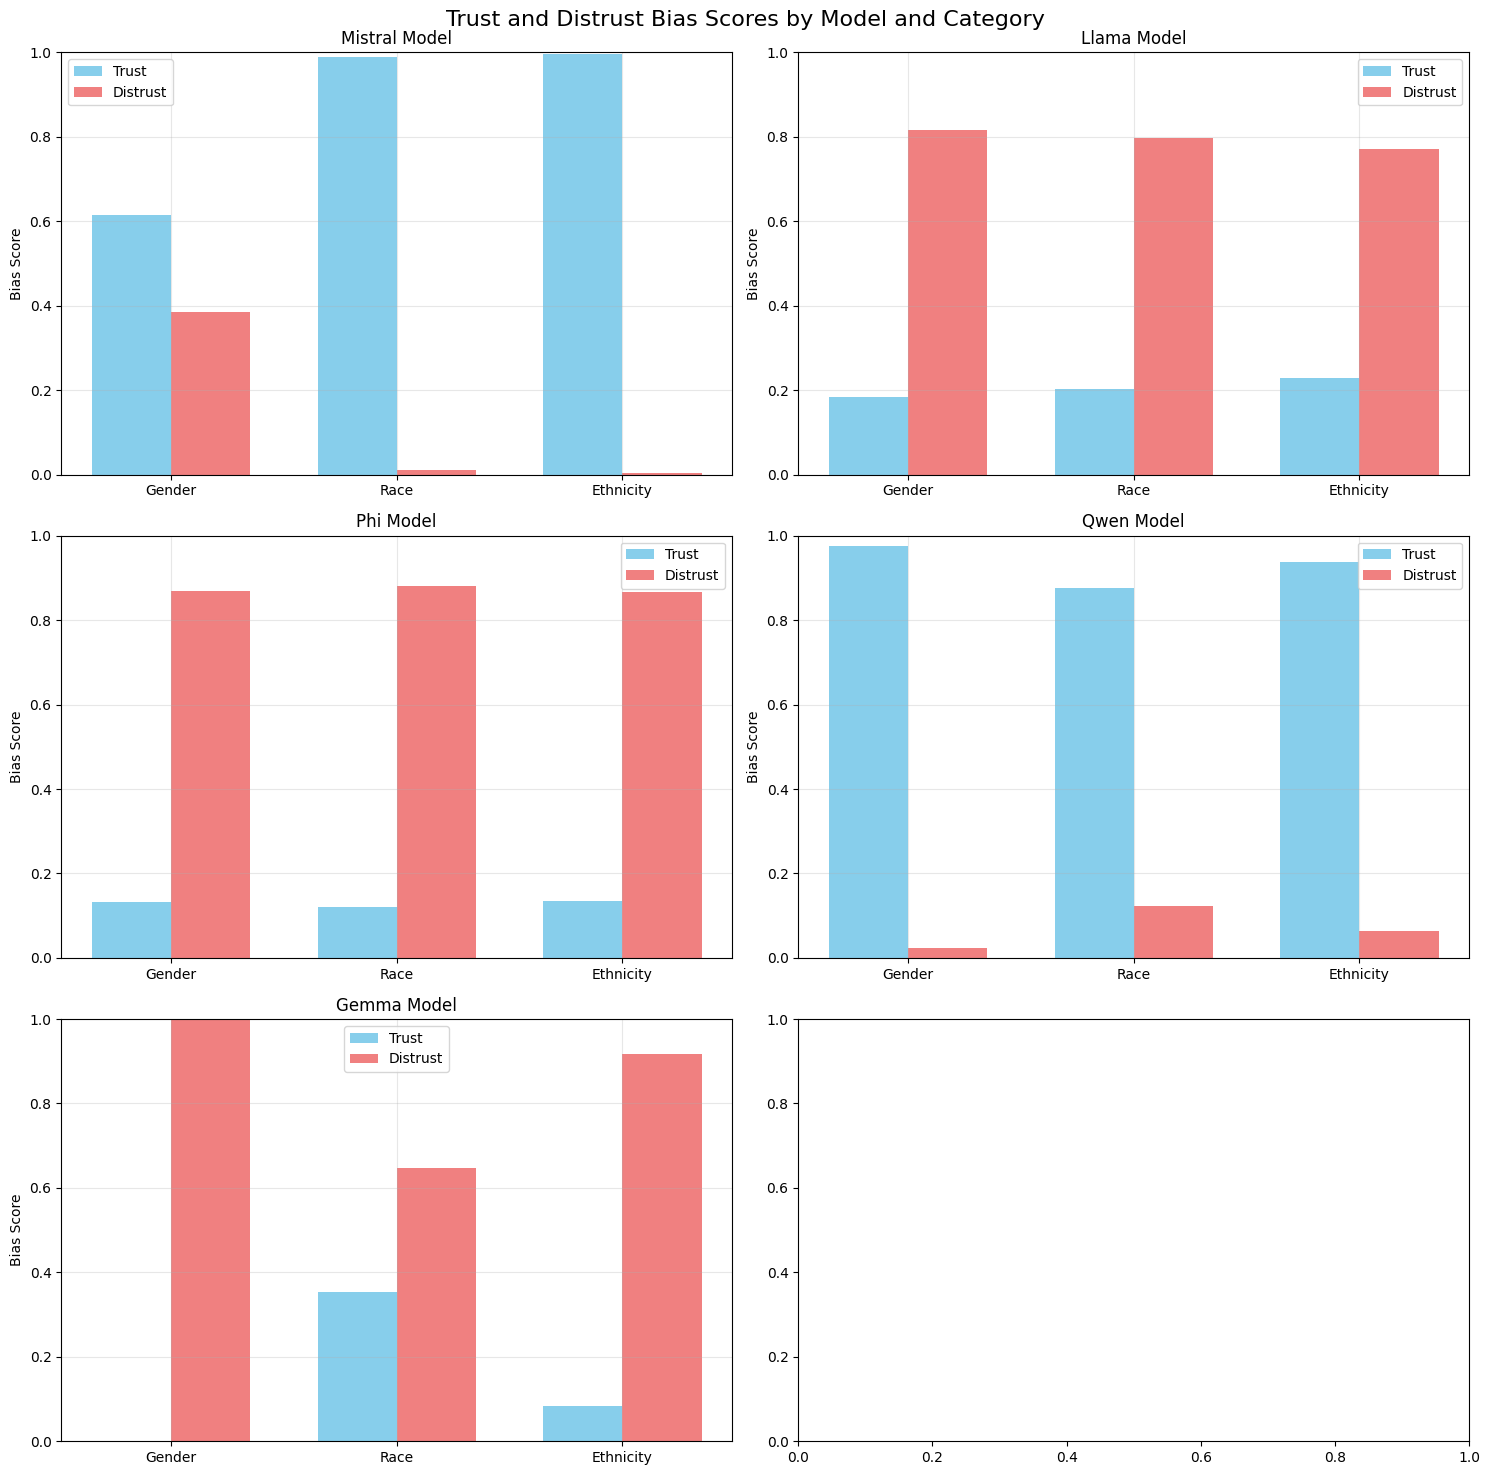

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Trust and Distrust Bias Scores by Model and Category', fontsize=16)

# Data for plotting
models = ['Mistral', 'Llama', 'Phi', 'Qwen', 'Gemma']
categories = ['Gender', 'Race', 'Ethnicity']

# Trust bias data
trust_data = {
    'Gender': [mistral_category_averages['gender']['trust_bias'], 
               llama_category_averages['gender']['trust_bias'],
               phi_category_averages['gender']['trust_bias'],
               qwen_category_averages['gender']['trust_bias'],
               gemma_category_averages['gender']['trust_bias']],
    'Race': [mistral_category_averages['race']['trust_bias'],
             llama_category_averages['race']['trust_bias'],
             phi_category_averages['race']['trust_bias'],
             qwen_category_averages['race']['trust_bias'],
             gemma_category_averages['race']['trust_bias']],
    'Ethnicity': [mistral_category_averages['ethnicity']['trust_bias'],
                  llama_category_averages['ethnicity']['trust_bias'],
                  phi_category_averages['ethnicity']['trust_bias'],
                  qwen_category_averages['ethnicity']['trust_bias'],
                  gemma_category_averages['ethnicity']['trust_bias']]
}

# Distrust bias data
distrust_data = {
    'Gender': [mistral_category_averages['gender']['distrust_bias'],
               llama_category_averages['gender']['distrust_bias'],
               phi_category_averages['gender']['distrust_bias'],
               qwen_category_averages['gender']['distrust_bias'],
               gemma_category_averages['gender']['distrust_bias']],
    'Race': [mistral_category_averages['race']['distrust_bias'],
             llama_category_averages['race']['distrust_bias'],
             phi_category_averages['race']['distrust_bias'],
             qwen_category_averages['race']['distrust_bias'],
             gemma_category_averages['race']['distrust_bias']],
    'Ethnicity': [mistral_category_averages['ethnicity']['distrust_bias'],
                  llama_category_averages['ethnicity']['distrust_bias'],
                  phi_category_averages['ethnicity']['distrust_bias'],
                  qwen_category_averages['ethnicity']['distrust_bias'],
                  gemma_category_averages['ethnicity']['distrust_bias']]
}

# Plot for each model
for i, model in enumerate(models):
    row = i // 2
    col = i % 2
    
    x = np.arange(len(categories))
    width = 0.35
    
    # Plot trust and distrust bars
    axes[row, col].bar(x - width/2, [trust_data[cat][i] for cat in categories], 
                      width, label='Trust', color='skyblue')
    axes[row, col].bar(x + width/2, [distrust_data[cat][i] for cat in categories], 
                      width, label='Distrust', color='lightcoral')
    
    axes[row, col].set_ylabel('Bias Score')
    axes[row, col].set_title(f'{model} Model')
    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(categories)
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)
    
    # Set y-axis limits to be consistent across all plots
    axes[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.show()



In [69]:
mistral_results[0]

{'chi2': 16.63417803768681,
 'p_value': 4.532682509811189e-05,
 'dof': 1,
 'is_significant': True,
 'expected': [0.81, 0.19],
 'observed': [0.97, 0.03],
 'persona': 'gender is female, race is caucasian',
 'gender': 'female',
 'race': 'caucasian',
 'ethnicity': None,
 'trust_estimate_probability_distribution': 0.97,
 'distrust_estimate_probability_distribution': 0.03,
 'trust_delta': 0.15999999999999992,
 'distrust_delta': -0.16,
 'trust_bias': 0.15999999999999992,
 'distrust_bias': -0.16}

## Calculating the trust & distrust value attribution among the available categories. For this we use the contribution of trust & distruct observed in individual cases

In [70]:
def calculate_category_attribution(result, category_averages):
    """
    Calculate the attribution of each category to the trust and distrust bias. Here we generate teh vector.
    """
    attribution = {
        'gender': {
            'trust_contribution': 0,
            'distrust_contribution': 0
        },
        'race': {
            'trust_contribution': 0,
            'distrust_contribution': 0
        },
        'ethnicity': {
            'trust_contribution': 0,
            'distrust_contribution': 0
        }
    }
    
    # Calculate total weight of present categories
    trust_total_weight = 0
    distrust_total_weight = 0
    if result['gender'] is not None:
        trust_total_weight += category_averages['gender']['trust_bias']
        distrust_total_weight += category_averages['gender']['distrust_bias']
    if result['race'] is not None:
        trust_total_weight += category_averages['race']['trust_bias']
        distrust_total_weight += category_averages['race']['distrust_bias']
    if result['ethnicity'] is not None:
        trust_total_weight += category_averages['ethnicity']['trust_bias']
        distrust_total_weight += category_averages['ethnicity']['distrust_bias']

    # Calculate contributions proportionally based on category weights
    if result['gender'] is not None:
        trust_weight = category_averages['gender']['trust_bias']
        distrust_weight = category_averages['gender']['distrust_bias']

        attribution['gender']['trust_contribution'] = (result['trust_bias'] * trust_weight) / trust_total_weight if trust_total_weight != 0 else 0
        attribution['gender']['distrust_contribution'] = (result['distrust_bias'] * distrust_weight) / distrust_total_weight if distrust_total_weight != 0 else 0
    else:
        attribution['gender']['trust_contribution'] = 0
        attribution['gender']['distrust_contribution'] = 0
    
    if result['race'] is not None:
        trust_weight = category_averages['race']['trust_bias']
        distrust_weight = category_averages['race']['distrust_bias']
        attribution['race']['trust_contribution'] = (result['trust_bias'] * trust_weight) / trust_total_weight if trust_total_weight != 0 else 0
        attribution['race']['distrust_contribution'] = (result['distrust_bias'] * distrust_weight) / distrust_total_weight if distrust_total_weight != 0 else 0
    else:
        attribution['race']['trust_contribution'] = 0
        attribution['race']['distrust_contribution'] = 0
    
    if result['ethnicity'] is not None:
        trust_weight = category_averages['ethnicity']['trust_bias']
        distrust_weight = category_averages['ethnicity']['distrust_bias']
        attribution['ethnicity']['trust_contribution'] = (result['trust_bias'] * trust_weight) / trust_total_weight if trust_total_weight != 0 else 0
        attribution['ethnicity']['distrust_contribution'] = (result['distrust_bias'] * distrust_weight) / distrust_total_weight if distrust_total_weight != 0 else 0
    else:
        attribution['ethnicity']['trust_contribution'] = 0
        attribution['ethnicity']['distrust_contribution'] = 0
    
    trust_contribution = [attribution['gender']['trust_contribution'], attribution['race']['trust_contribution'], attribution['ethnicity']['trust_contribution']]
    distrust_contribution = [attribution['gender']['distrust_contribution'], attribution['race']['distrust_contribution'], attribution['ethnicity']['distrust_contribution']]
    return trust_contribution, distrust_contribution

def add_attribution_vectors(results, category_averages):
    for result in results:
        trust_contrib, distrust_contrib = calculate_category_attribution(result, category_averages)
        result['vector_order'] = ['gender', 'race', 'ethnicity']
        result['trust_vector'] = trust_contrib
        result['distrust_vector'] = distrust_contrib
    return results

# Add attribution vectors to both result sets
mistral_results = add_attribution_vectors(mistral_results, mistral_category_averages)
llama_results = add_attribution_vectors(llama_results, llama_category_averages)
phi_results = add_attribution_vectors(phi_results, phi_category_averages)
qwen_results = add_attribution_vectors(qwen_results, qwen_category_averages)
gemma_results = add_attribution_vectors(gemma_results, gemma_category_averages)


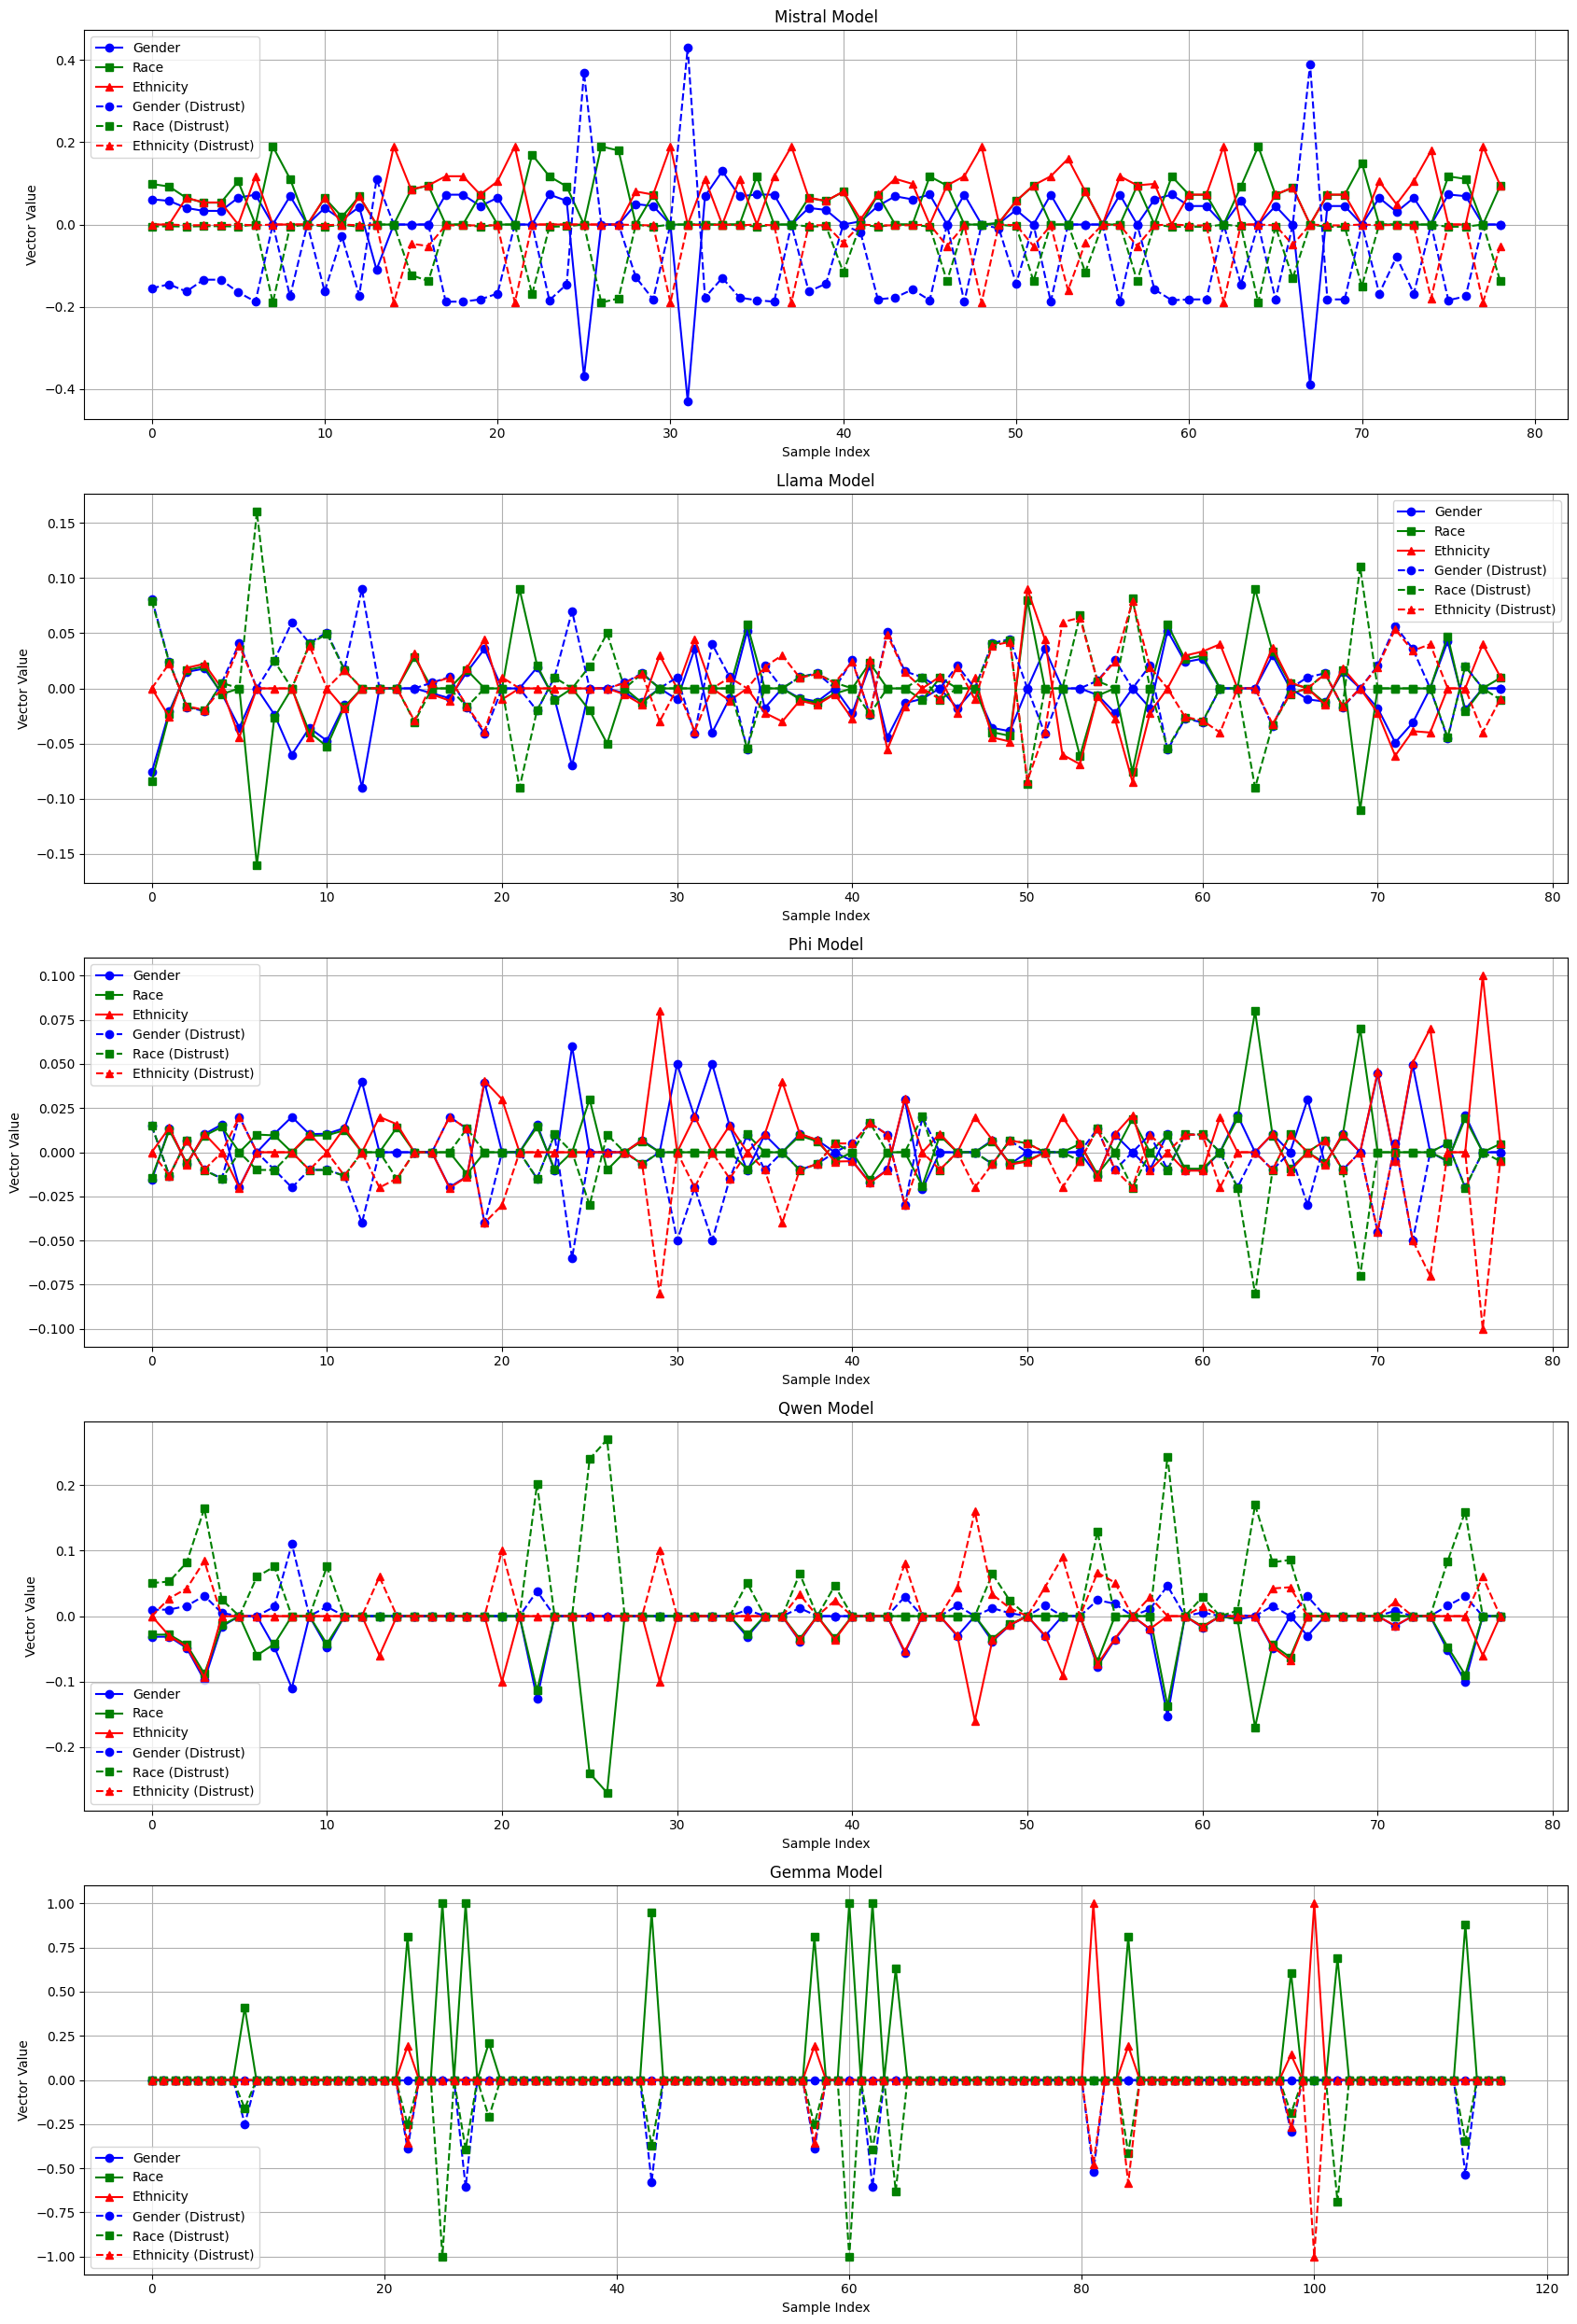

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 5 subplots (one for each model)
fig, axes = plt.subplots(5, 1, figsize=(17, 25))

# List of models and their results
models = [
    ('Mistral', mistral_results),
    ('Llama', llama_results),
    ('Phi', phi_results),
    ('Qwen', qwen_results),
    ('Gemma', gemma_results)
]

# Plot each model's data
for idx, (model_name, results) in enumerate(models):
    ax = axes[idx]
    
    # Extract vectors
    trust_vectors = np.array([r['trust_vector'] for r in results])
    distrust_vectors = np.array([r['distrust_vector'] for r in results])
    
    # Plot trust vectors
    ax.plot(trust_vectors[:, 0], label='Gender', color='blue', marker='o')
    ax.plot(trust_vectors[:, 1], label='Race', color='green', marker='s')
    ax.plot(trust_vectors[:, 2], label='Ethnicity', color='red', marker='^')
    
    # Plot distrust vectors
    ax.plot(distrust_vectors[:, 0], label='Gender (Distrust)', color='blue', linestyle='--', marker='o')
    ax.plot(distrust_vectors[:, 1], label='Race (Distrust)', color='green', linestyle='--', marker='s')
    ax.plot(distrust_vectors[:, 2], label='Ethnicity (Distrust)', color='red', linestyle='--', marker='^')
    
    ax.set_title(f'{model_name} Model')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Vector Value')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


/var/folders/55/jvwnrxxn7359lr9zvvl8vg100000gn/T/ipykernel_51862/467538269.py:44: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



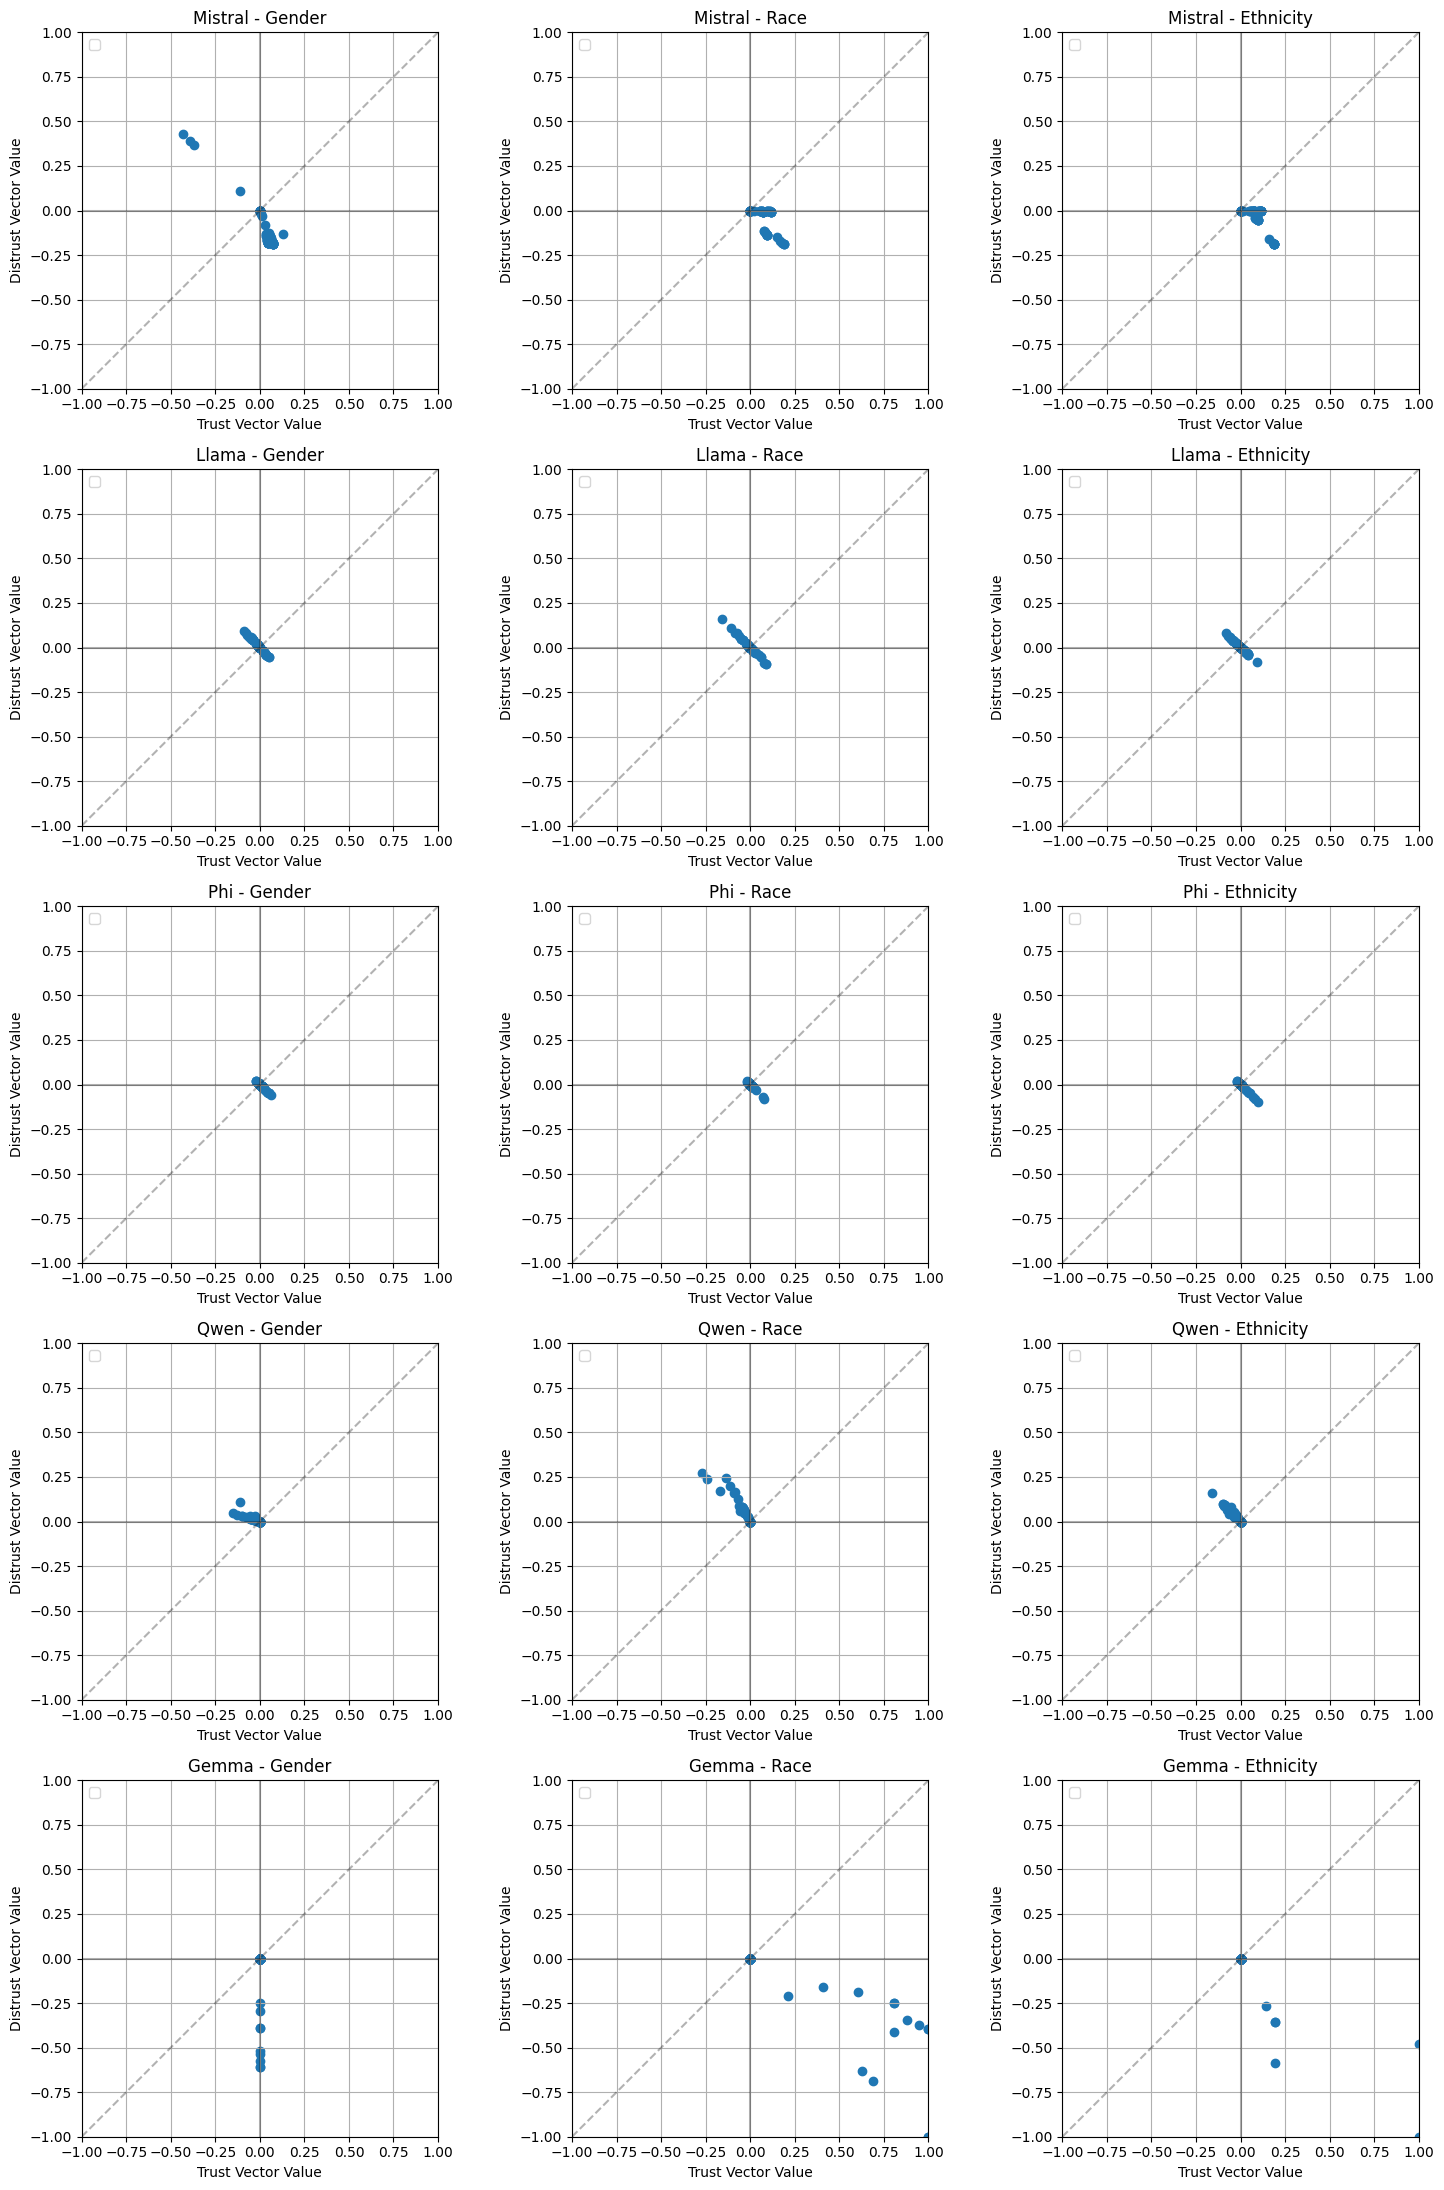

In [72]:
# Create a figure with 5x3 subplots (5 models x 3 categories)
fig, axes = plt.subplots(5, 3, figsize=(15, 22))  # Reduced size to 75%

# Categories to analyze
categories = ['gender', 'race', 'ethnicity']

# Plot each model and category combination
for model_idx, (model_name, results) in enumerate(models):
    for category_idx, category in enumerate(categories):
        ax = axes[model_idx, category_idx]
        
        # Extract vectors for this category
        trust_vectors = np.array([r['trust_vector'] for r in results])
        distrust_vectors = np.array([r['distrust_vector'] for r in results])
        
        # Get the index of the current category in the vector
        category_idx_in_vector = results[0]['vector_order'].index(category)
        
        # Plot trust vs distrust for this category with different colors
        ax.scatter(trust_vectors[:, category_idx_in_vector], 
                  distrust_vectors[:, category_idx_in_vector])
        
        # Add diagonal line representing equal trust/distrust
        ax.plot([-1, 1], [-1, 1], 'k--', alpha=0.3)
        
        # Add quadrant lines
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        
        # Set title and labels
        ax.set_title(f'{model_name} - {category.capitalize()}')
        ax.set_xlabel('Trust Vector Value')
        ax.set_ylabel('Distrust Vector Value')
        ax.grid(True)
        
        # Set equal aspect ratio
        ax.set_aspect('equal')
        
        # Set axis limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        
        # Add legend
        ax.legend()

plt.tight_layout()
plt.show()




In [113]:
import plotly.express as px
import pandas as pd
import numpy as np

def create_bias_score_heatmap(models):
    data = []
    for model_name, results in models:
        vector_order = results[0]['vector_order']
        trust_vectors = np.array([r['trust_vector'] for r in results])
        distrust_vectors = np.array([r['distrust_vector'] for r in results])

        for i, cat in enumerate(vector_order):
            trust_avg = np.mean(trust_vectors[:, i])
            distrust_avg = np.mean(distrust_vectors[:, i])
            dist = np.sqrt(trust_avg**2 + distrust_avg**2)
            data.append({"Model": model_name, "Category": cat.capitalize(), "Bias Distance": dist})

    df = pd.DataFrame(data)
    pivot_df = df.pivot(index="Category", columns="Model", values="Bias Distance")

    fig = px.imshow(
        pivot_df,
        text_auto=".2f",
        color_continuous_scale="YlOrRd",
        aspect="auto",
        title="Bias Strength Across Models and Categories"
    )

    fig.update_layout(
        xaxis_title="Model",
        yaxis_title="Category",
        coloraxis_colorbar=dict(title="Bias Distance"),
        font=dict(size=14),
        paper_bgcolor="#ffffff",
        plot_bgcolor="#ffffff"
    )

    return fig

In [114]:
create_bias_score_heatmap(models)

In [80]:
mistral_results[0]

{'chi2': 16.63417803768681,
 'p_value': 4.532682509811189e-05,
 'dof': 1,
 'is_significant': True,
 'expected': [0.81, 0.19],
 'observed': [0.97, 0.03],
 'persona': 'gender is female, race is caucasian',
 'gender': 'female',
 'race': 'caucasian',
 'ethnicity': None,
 'trust_estimate_probability_distribution': 0.97,
 'distrust_estimate_probability_distribution': 0.03,
 'trust_delta': 0.15999999999999992,
 'distrust_delta': -0.16,
 'trust_bias': 0.15999999999999992,
 'distrust_bias': -0.16,
 'vector_order': ['gender', 'race', 'ethnicity'],
 'trust_vector': [0.061372141372141344, 0.09862785862785857, 0],
 'distrust_vector': [-0.15529411764705883, -0.004705882352941177, 0]}

In [81]:
import json

# Save Mistral results
with open('mistral_results.json', 'w') as f:
    json.dump(mistral_results, f, indent=2)

# Save Llama results
with open('llama_results.json', 'w') as f:
    json.dump(llama_results, f, indent=2)

# Save Phi results
with open('phi_results.json', 'w') as f:
    json.dump(phi_results, f, indent=2)

# Save Qwen results
with open('qwen_results.json', 'w') as f:
    json.dump(qwen_results, f, indent=2)

# Save Gemma results
with open('gemma_results.json', 'w') as f:
    json.dump(gemma_results, f, indent=2)


### Once we have the bias vector for each persona we calculate the central point of those which can be considred for the calculation of the bias towards a category and bias towards a value in a category. We do this by considering distance and location of the central point

In [82]:
def calculate_category_bias_scores(results, category):
    """ Calculate the bias scores for a given category """
    # Filter results that have the specified category
    category_results = [r for r in results if r[category] is not None]
    
    if not category_results:
        return None, None
    
    # Extract all trust and distrust vectors
    all_trust_vectors = [r['trust_vector'] for r in category_results]
    all_distrust_vectors = [r['distrust_vector'] for r in category_results]
    
    # Calculate center points across all categories
    trust_center = [sum(vectors) / len(vectors) for vectors in zip(*all_trust_vectors)]
    distrust_center = [sum(vectors) / len(vectors) for vectors in zip(*all_distrust_vectors)]

    # Calculate distance from origin for trust and distrust centers
    trust_distance = sum(x**2 for x in trust_center)**0.5
    distrust_distance = sum(x**2 for x in distrust_center)**0.5

    # Calculate Manhattan distance for trust and distrust centers
    trust_manhattan = sum(abs(x) for x in trust_center)
    distrust_manhattan = sum(abs(x) for x in distrust_center)

    # Direct sum of trust and distrust vectors  
    trust_direct_sum = sum(trust_center)
    distrust_direct_sum = sum(distrust_center)
    
    return trust_distance, distrust_distance, trust_manhattan, distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center

# Calculate bias scores for each category
categories = ['gender', 'race', 'ethnicity']
mistral_category_bias_scores = {}
llama_category_bias_scores = {}
phi_category_bias_scores = {}
qwen_category_bias_scores = {}
gemma_category_bias_scores = {}

for category in categories:
    mistral_category_bias_scores[category] = calculate_category_bias_scores(mistral_results, category)
    llama_category_bias_scores[category] = calculate_category_bias_scores(llama_results, category)
    phi_category_bias_scores[category] = calculate_category_bias_scores(phi_results, category)
    qwen_category_bias_scores[category] = calculate_category_bias_scores(qwen_results, category)
    gemma_category_bias_scores[category] = calculate_category_bias_scores(gemma_results, category)

print("Mistral Category Bias Scores:")
for category, (trust, distrust, trust_manhattan , distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center) in mistral_category_bias_scores.items():
    print(f"{category}: trust={trust:.4f}, distrust={distrust:.4f}, trust_manhattan={trust_manhattan:.4f}, distrust_manhattan={distrust_manhattan:.4f}, trust_direct_sum={trust_direct_sum:.4f}, distrust_direct_sum={distrust_direct_sum:.4f}, trust_center={trust_center}, distrust_center={distrust_center}")

print("\nLlama Category Bias Scores:")
for category, (trust, distrust, trust_manhattan , distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center) in llama_category_bias_scores.items():
    print(f"{category}: trust={trust:.4f}, distrust={distrust:.4f}, trust_manhattan={trust_manhattan:.4f}, distrust_manhattan={distrust_manhattan:.4f}, trust_direct_sum={trust_direct_sum:.4f}, distrust_direct_sum={distrust_direct_sum:.4f}, trust_center={trust_center}, distrust_center={distrust_center}")

print("\nPhi Category Bias Scores:")
for category, (trust, distrust, trust_manhattan , distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center) in phi_category_bias_scores.items():
    print(f"{category}: trust={trust:.4f}, distrust={distrust:.4f}, trust_manhattan={trust_manhattan:.4f}, distrust_manhattan={distrust_manhattan:.4f}, trust_direct_sum={trust_direct_sum:.4f}, distrust_direct_sum={distrust_direct_sum:.4f}, trust_center={trust_center}, distrust_center={distrust_center}")

print("\nQwen Category Bias Scores:")
for category, (trust, distrust, trust_manhattan , distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center) in qwen_category_bias_scores.items():
    print(f"{category}: trust={trust:.4f}, distrust={distrust:.4f}, trust_manhattan={trust_manhattan:.4f}, distrust_manhattan={distrust_manhattan:.4f}, trust_direct_sum={trust_direct_sum:.4f}, distrust_direct_sum={distrust_direct_sum:.4f}, trust_center={trust_center}, distrust_center={distrust_center}")

print("\nGemma Category Bias Scores:")
for category, (trust, distrust, trust_manhattan , distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center) in gemma_category_bias_scores.items():
    print(f"{category}: trust={trust:.4f}, distrust={distrust:.4f}, trust_manhattan={trust_manhattan:.4f}, distrust_manhattan={distrust_manhattan:.4f}, trust_direct_sum={trust_direct_sum:.4f}, distrust_direct_sum={distrust_direct_sum:.4f}, trust_center={trust_center}, distrust_center={distrust_center}")



Mistral Category Bias Scores:
gender: trust=0.0727, distrust=0.1177, trust_manhattan=0.1215, distrust_manhattan=0.1215, trust_direct_sum=0.1215, distrust_direct_sum=-0.1215, trust_center=[0.025901986439175087, 0.04312060272556209, 0.05243195628980822], distrust_center=[-0.11766806444642416, -0.002614425101678345, -0.0011720522700793305]
race: trust=0.1060, distrust=0.1159, trust_manhattan=0.1654, distrust_manhattan=0.1654, trust_direct_sum=0.1654, distrust_direct_sum=-0.1654, trust_center=[0.03208199399938715, 0.09236270426207505, 0.04099008434723339], distrust_center=[-0.10315612085969991, -0.0518890600578538, -0.010389597125924573]
ethnicity: trust=0.1103, distrust=0.1134, trust_manhattan=0.1670, distrust_manhattan=0.1670, trust_direct_sum=0.1670, distrust_direct_sum=-0.1670, trust_center=[0.03298941446247699, 0.03466417165252456, 0.09938345092203543], distrust_center=[-0.10340919507887428, -0.023232293573248006, -0.04039554338491477]

Llama Category Bias Scores:
gender: trust=0.0116

In [83]:
def calculate_category_value_bias_scores(results, category, value):
    # Filter results that have the specified category and value
    category_results = [r for r in results if r[category] == value]
    
    if not category_results:
        return None, None
    
    # Extract all trust and distrust vectors
    all_trust_vectors = [r['trust_vector'] for r in category_results]
    all_distrust_vectors = [r['distrust_vector'] for r in category_results]
    
    # Calculate center points across all categories
    trust_center = [sum(vectors) / len(vectors) for vectors in zip(*all_trust_vectors)]
    distrust_center = [sum(vectors) / len(vectors) for vectors in zip(*all_distrust_vectors)]

    # Calculate distance from origin for trust and distrust centers
    trust_distance = sum(x**2 for x in trust_center)**0.5
    distrust_distance = sum(x**2 for x in distrust_center)**0.5

    # Calculate Manhattan distance for trust and distrust centers
    trust_manhattan = sum(abs(x) for x in trust_center)
    distrust_manhattan = sum(abs(x) for x in distrust_center)

    # Direct sum of trust and distrust vectors
    trust_direct_sum = sum(trust_center)
    distrust_direct_sum = sum(distrust_center)
    
    return trust_distance, distrust_distance, trust_manhattan, distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center

# Calculate bias scores for gender values
gender_values = ['male', 'female']
race_values = ["black", "caucasian"]
ethnicity_values = ["african american", "asian", "hispanic"]

mistral_bias_scores = {}
llama_bias_scores = {}
phi_bias_scores = {}
qwen_bias_scores = {}
gemma_bias_scores = {}

# Calculate and print bias scores for all category values
categories = {
    'gender': gender_values,
    'race': race_values,
    'ethnicity': ethnicity_values
}

def calculate_and_print_bias_scores(model_results, model_name, categories):
    bias_scores = {}
    
    for category, values in categories.items():
        print(f"\n{model_name} {category.capitalize()} Value Bias Scores:")
        for value in values:
            bias_scores[value] = calculate_category_value_bias_scores(model_results, category, value)
            if bias_scores[value][0] is not None:  # Check if results exist
                trust, distrust, trust_manhattan, distrust_manhattan, trust_direct_sum, distrust_direct_sum, trust_center, distrust_center = bias_scores[value]
                print(f"{value}: trust={trust:.4f}, distrust={distrust:.4f}, trust_manhattan={trust_manhattan:.4f}, distrust_manhattan={distrust_manhattan:.4f}, trust_center={trust_center}, distrust_center={distrust_center}")
    
    return bias_scores

# Calculate bias scores for all models
mistral_bias_scores = calculate_and_print_bias_scores(mistral_results, "Mistral", categories)
llama_bias_scores = calculate_and_print_bias_scores(llama_results, "Llama", categories)
phi_bias_scores = calculate_and_print_bias_scores(phi_results, "Phi", categories)
qwen_bias_scores = calculate_and_print_bias_scores(qwen_results, "Qwen", categories)
gemma_bias_scores = calculate_and_print_bias_scores(gemma_results, "Gemma", categories)



Mistral Gender Value Bias Scores:
male: trust=0.0606, distrust=0.0800, trust_manhattan=0.0869, distrust_manhattan=0.0833, trust_center=[-0.0017651128078527245, 0.03753673725029003, 0.04756170889089596], distrust_center=[-0.08000537010916273, -0.002273218251377498, -0.0010547420098301582]
female: trust=0.0915, distrust=0.1540, trust_manhattan=0.1582, distrust_manhattan=0.1582, trust_center=[0.052580974998809045, 0.04850504443386015, 0.057128266281616456], distrust_center=[-0.15398566255735482, -0.0029434459930398754, -0.001285172878176747]

Mistral Race Value Bias Scores:
black: trust=0.1208, distrust=0.1323, trust_manhattan=0.1856, distrust_manhattan=0.1856, trust_center=[0.03800172702053847, 0.10740177471780224, 0.04015205381721479], distrust_center=[-0.11902476244554887, -0.05709339870350497, -0.009437386073168401]
caucasian: trust=0.0968, distrust=0.1054, trust_manhattan=0.1525, distrust_manhattan=0.1525, trust_center=[0.028276451342932735, 0.08269473039767898, 0.0415288182593882],

In [84]:
mistral_bias_scores

{'male': (0.06061549652724202,
  0.08004460786480128,
  0.08686355894903872,
  0.08333333037037038,
  0.08333333333333327,
  -0.08333333037037038,
  [-0.0017651128078527245, 0.03753673725029003, 0.04756170889089596],
  [-0.08000537010916273, -0.002273218251377498, -0.0010547420098301582]),
 'female': (0.0915485503746477,
  0.15401915405841018,
  0.15821428571428564,
  0.15821428142857144,
  0.15821428571428564,
  -0.15821428142857144,
  [0.052580974998809045, 0.04850504443386015, 0.057128266281616456],
  [-0.15398566255735482, -0.0029434459930398754, -0.001285172878176747]),
 'black': (0.12079511535992497,
  0.13234656968214462,
  0.1855555555555555,
  0.18555554722222223,
  0.1855555555555555,
  -0.18555554722222223,
  [0.03800172702053847, 0.10740177471780224, 0.04015205381721479],
  [-0.11902476244554887, -0.05709339870350497, -0.009437386073168401]),
 'caucasian': (0.0967606267141514,
  0.10544242751867429,
  0.1524999999999999,
  0.15249999785714285,
  0.1524999999999999,
  -0.152

In [109]:
# Function to save bias scores to a JSON file
def save_bias_scores_to_json(model_scores_dict, filename="bias_scores.json"):
    import json
    
    # Create a dictionary to store all scores
    all_scores = {}
    
    def process_model_scores(model_name, bias_scores, category_scores):
        model_data = {
            "category_scores": {},
            "value_scores": {}
        }
        
        # Process category scores
        for category, scores in category_scores.items():
            if scores[0] is not None:  # Check if results exist
                trust, distrust, trust_manhattan, distrust_manhattan,  trust_direct_sum, distrust_direct_sum, trust_center, distrust_center = scores
                model_data["category_scores"][category] = {
                    "trust_distance": trust,
                    "distrust_distance": distrust,
                    "trust_manhattan": trust_manhattan,
                    "distrust_manhattan": distrust_manhattan,
                    "trust_direct_sum": trust_direct_sum,
                    "distrust_direct_sum": distrust_direct_sum,
                    "trust_center": trust_center,
                    "distrust_center": distrust_center
                }
        
        # Process value scores
        for value, scores in bias_scores.items():
            if scores[0] is not None:  # Check if results exist
                trust, distrust, trust_manhattan, distrust_manhattan,  trust_direct_sum, distrust_direct_sum, trust_center, distrust_center = scores
                model_data["value_scores"][value] = {
                    "trust_distance": trust,
                    "distrust_distance": distrust,
                    "trust_manhattan": trust_manhattan,
                    "distrust_manhattan": distrust_manhattan,
                    "trust_direct_sum": trust_direct_sum,
                    "distrust_direct_sum": distrust_direct_sum,
                    "trust_center": trust_center,
                    "distrust_center": distrust_center
                }
        
        return model_data
    
    # Process each model's scores
    for model_name, (bias_scores, category_scores) in model_scores_dict.items():
        all_scores[model_name.lower()] = process_model_scores(model_name, bias_scores, category_scores)
    
    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump(all_scores, f, indent=2)
    
    print(f"Bias scores saved to {filename}")

# Create dictionary of model scores
model_scores = {
    "Mistral": (mistral_bias_scores, mistral_category_bias_scores),
    "Llama": (llama_bias_scores, llama_category_bias_scores),
    "Phi": (phi_bias_scores, phi_category_bias_scores),
    "Qwen": (qwen_bias_scores, qwen_category_bias_scores),
    "Gemma": (gemma_bias_scores, gemma_category_bias_scores)
}

# Save the bias scores
save_bias_scores_to_json(model_scores)


Bias scores saved to bias_scores.json


In [86]:
%pip install pandas openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [110]:
import pandas as pd
import json

def save_bias_scores_to_excel(json_file="bias_scores.json", excel_file="bias_scores.xlsx"):
    # Read the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Create empty lists to store data
    rows = []
    
    # Process all models data
    models = ["mistral", "llama", "phi", "qwen", "gemma"]
    for model_name in models:
        if model_name in data:
            for category, scores in data[model_name]["category_scores"].items():
                row = {
                    'Model': model_name.capitalize(),
                    'Category': category,
                    'Trust Distance': scores['trust_distance'],
                    'Distrust Distance': scores['distrust_distance'],
                    'Trust Manhattan': scores['trust_manhattan'],
                    'Distrust Manhattan': scores['distrust_manhattan'],
                    'Trust Center': str(scores['trust_center']),
                    'Distrust Center': str(scores['distrust_center'])
                }
                rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Create Excel writer
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        # Save main sheet with all data
        df.to_excel(writer, sheet_name='All Data', index=False)
        
        # Create separate sheets for each model
        for model in [m.capitalize() for m in models]:
            model_df = df[df['Model'] == model]
            if not model_df.empty:
                model_df.to_excel(writer, sheet_name=f'{model}_Data', index=False)
        
        # Create separate sheets for trust and distrust metrics
        trust_cols = [col for col in df.columns if 'Trust' in col]
        distrust_cols = [col for col in df.columns if 'Distrust' in col]
        
        df[trust_cols].to_excel(writer, sheet_name='Trust_Metrics', index=False)
        df[distrust_cols].to_excel(writer, sheet_name='Distrust_Metrics', index=False)
        
        # Create pivot tables for different views
        pivot_trust = df.pivot_table(
            values='Trust Distance',
            index='Category',
            columns='Model',
            aggfunc='mean'
        )
        pivot_trust.to_excel(writer, sheet_name='Trust_Summary')
        
        pivot_distrust = df.pivot_table(
            values='Distrust Distance',
            index='Category',
            columns='Model',
            aggfunc='mean'
        )
        pivot_distrust.to_excel(writer, sheet_name='Distrust_Summary')

# Save the results to Excel
save_bias_scores_to_excel()


In [88]:
%pip install pandas tabulate openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [112]:
import pandas as pd
from tabulate import tabulate

import json

# Read the bias scores from JSON file
with open('bias_scores.json', 'r') as f:
    model_scores = json.load(f)

# Print the structure of the loaded data
print("Available models:", list(model_scores.keys()))

# Function to convert nested dict to DataFrame
def parse_scores(score_dict):
    data = []
    for label, metrics in score_dict.items():
        row = {
            "label": label,
            "trust_distance": metrics["trust_distance"],
            "distrust_distance": metrics["distrust_distance"],
            "trust_manhattan": metrics["trust_manhattan"],
            "distrust_manhattan": metrics["distrust_manhattan"],
            "trust_direct_sum": metrics["trust_direct_sum"],
            "distrust_direct_sum": metrics["distrust_direct_sum"],
            "trust_center_x": metrics["trust_center"][0],
            "trust_center_y": metrics["trust_center"][1],
            "trust_center_z": metrics["trust_center"][2],
            "distrust_center_x": metrics["distrust_center"][0],
            "distrust_center_y": metrics["distrust_center"][1],
            "distrust_center_z": metrics["distrust_center"][2],
        }
        data.append(row)
    return pd.DataFrame(data)

# Process each model
for model_name, scores in model_scores.items():
    print(f"\n=== Model: {model_name.upper()} ===")

    category_df = parse_scores(scores["category_scores"])
    value_df = parse_scores(scores["value_scores"])

    if not category_df.empty:
        print("\n>>> Category Scores:")
        print(tabulate(category_df, headers="keys", tablefmt="grid", showindex=False))
    else:
        print("\n>>> Category Scores: No data")

    if not value_df.empty:
        print("\n>>> Value Scores:")
        print(tabulate(value_df, headers="keys", tablefmt="grid", showindex=False))
    else:
        print("\n>>> Value Scores: No data")

    # Optional: Save to Excel
    # category_df.to_excel(f"{model_name}_category_scores.xlsx", index=False)
    # value_df.to_excel(f"{model_name}_value_scores.xlsx", index=False)


Available models: ['mistral', 'llama', 'phi', 'qwen', 'gemma']

=== Model: MISTRAL ===

>>> Category Scores:
+-----------+------------------+---------------------+-------------------+----------------------+--------------------+-----------------------+------------------+------------------+------------------+---------------------+---------------------+---------------------+
| label     |   trust_distance |   distrust_distance |   trust_manhattan |   distrust_manhattan |   trust_direct_sum |   distrust_direct_sum |   trust_center_x |   trust_center_y |   trust_center_z |   distrust_center_x |   distrust_center_y |   distrust_center_z |
+===========+==================+=====================+===================+======================+====================+=======================+==================+==================+==================+=====================+=====================+=====================+
| gender    |        0.0726595 |            0.117703 |          0.121455 |             0.1214

In [90]:
# Create Excel writer object
with pd.ExcelWriter('/Users/appikatlaanudeep/Documents/projects/quant-cognitive-bias-llm/Muralicode/model_scores_analysis.xlsx') as writer:
    # Process each model
    for model_name, scores in model_scores.items():
        # Get category and value scores
        category_df = parse_scores(scores["category_scores"])
        value_df = parse_scores(scores["value_scores"])
        
        # Save to different sheets
        if not category_df.empty:
            category_df.to_excel(writer, sheet_name=f'{model_name}_categories', index=False)
        if not value_df.empty:
            value_df.to_excel(writer, sheet_name=f'{model_name}_values', index=False)

print("Scores have been saved to 'model_scores_analysis.xlsx'")


Scores have been saved to 'model_scores_analysis.xlsx'


In [91]:
category_df.head()

,label,trust_distance,distrust_distance,trust_manhattan,distrust_manhattan,trust_direct_sum,distrust_direct_sum,trust_center_x,trust_center_y,trust_center_z,distrust_center_x,distrust_center_y,distrust_center_z
0,gender,0.079075,0.059622,0.095119,0.095119,0.095119,-0.095119,0.0,0.076962,0.018157,-0.049629,-0.028091,-0.017399
1,race,0.152500,0.104925,0.162254,0.162254,0.162254,-0.162254,0.0,0.152166,0.010087,-0.051367,-0.088781,-0.022106
2,ethnicity,0.052884,0.046930,0.074675,0.074675,0.074675,-0.074675,0.0,0.039400,0.035275,-0.020707,-0.014387,-0.039582


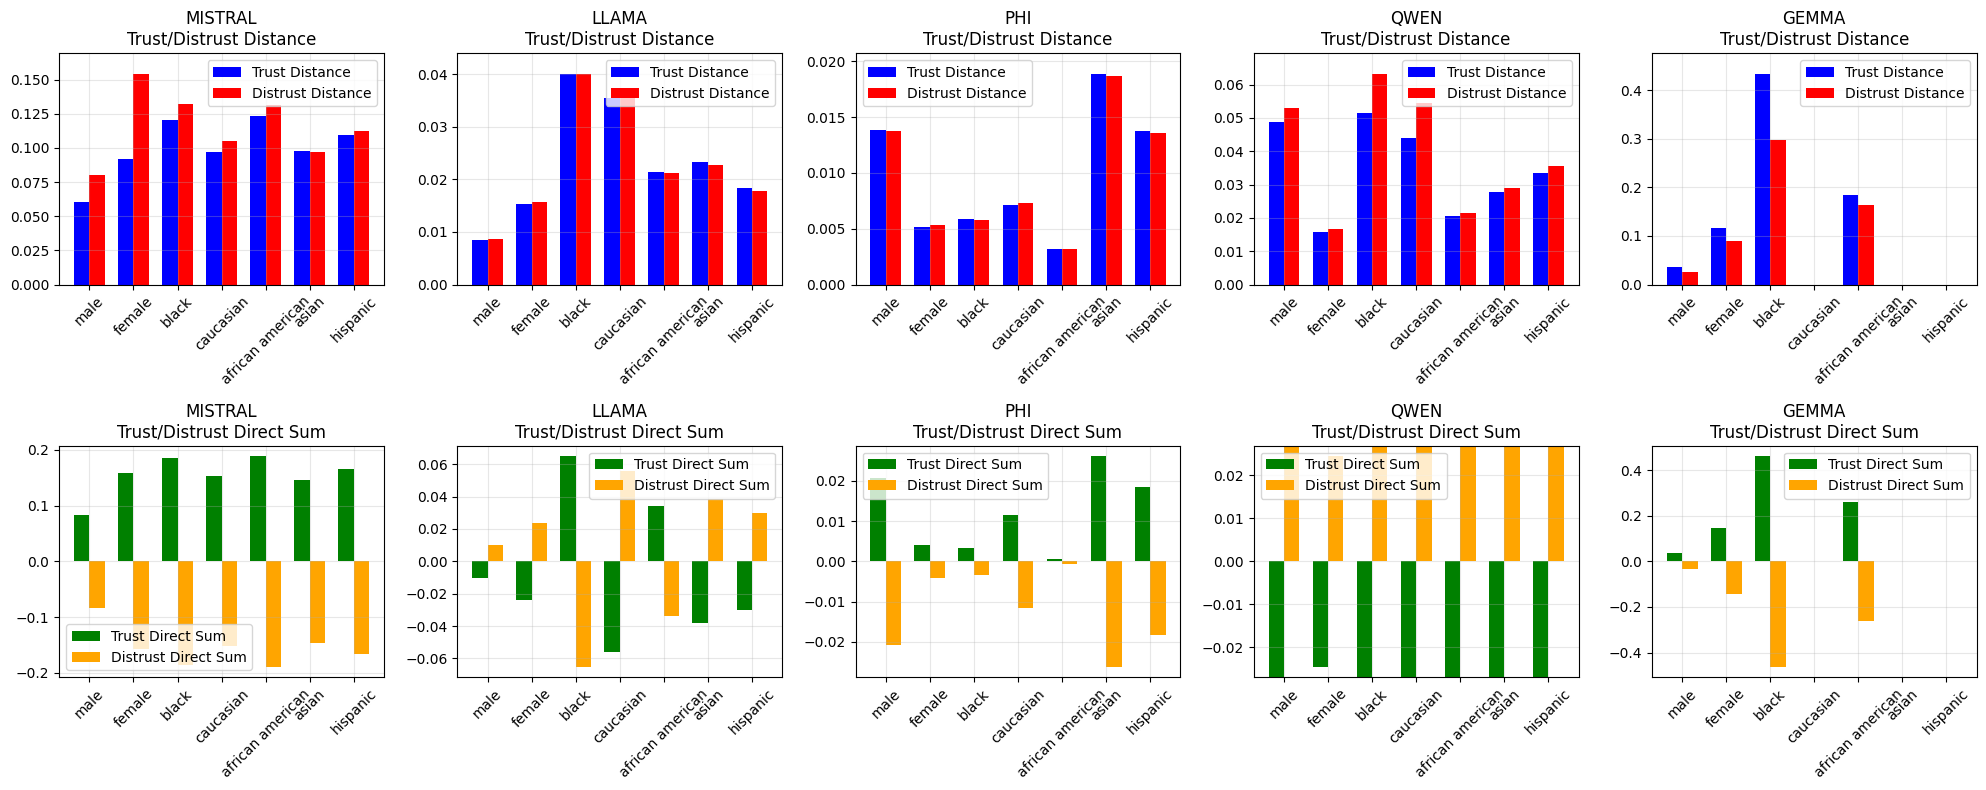

In [92]:
def plot_model_comparison(model_scores):
    # Create a figure with 2 rows and 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Process each model
    for idx, (model_name, scores) in enumerate(model_scores.items()):
        values_df = parse_scores(scores["value_scores"])
        
        if not values_df.empty:
            # First row: trust_distance and distrust_distance
            x = np.arange(len(values_df))
            width = 0.35
            
            # Plot trust and distrust distances
            axes[0, idx].bar(x - width/2, values_df['trust_distance'], width, label='Trust Distance', color='blue')
            axes[0, idx].bar(x + width/2, values_df['distrust_distance'], width, label='Distrust Distance', color='red')
            
            axes[0, idx].set_title(f'{model_name.upper()}\nTrust/Distrust Distance')
            axes[0, idx].set_xticks(x)
            axes[0, idx].set_xticklabels(values_df['label'], rotation=45)
            axes[0, idx].legend()
            axes[0, idx].grid(True, alpha=0.3)
            
            # Second row: trust_direct_sum and distrust_direct_sum
            axes[1, idx].bar(x - width/2, values_df['trust_direct_sum'], width, label='Trust Direct Sum', color='green')
            axes[1, idx].bar(x + width/2, values_df['distrust_direct_sum'], width, label='Distrust Direct Sum', color='orange')
            
            axes[1, idx].set_title(f'{model_name.upper()}\nTrust/Distrust Direct Sum')
            axes[1, idx].set_xticks(x)
            axes[1, idx].set_xticklabels(values_df['label'], rotation=45)
            axes[1, idx].legend()
            axes[1, idx].grid(True, alpha=0.3)
            
            # Set y-axis limits to be consistent across all plots in each row
            max_val_row1 = max(values_df['trust_distance'].max(), values_df['distrust_distance'].max())
            max_val_row2 = max(values_df['trust_direct_sum'].max(), abs(values_df['distrust_direct_sum'].min()))
            
            axes[0, idx].set_ylim(0, max_val_row1 * 1.1)
            axes[1, idx].set_ylim(-max_val_row2 * 1.1, max_val_row2 * 1.1)
    
    plt.tight_layout()
    plt.show()

# Call the function with the model scores
plot_model_comparison(model_scores)


In [93]:
value_df.head(10)

,label,trust_distance,distrust_distance,trust_manhattan,distrust_manhattan,trust_direct_sum,distrust_direct_sum,trust_center_x,trust_center_y,trust_center_z,distrust_center_x,distrust_center_y,distrust_center_z
0,male,0.035789,0.025882,0.035789,0.035789,0.035789,-0.035789,0.0,0.035789,0.000000,-0.021730,-0.014059,0.000000
1,female,0.115821,0.088690,0.144130,0.144130,0.144130,-0.144130,0.0,0.110974,0.033157,-0.072675,-0.039682,-0.031773
2,black,0.433101,0.297987,0.460800,0.460800,0.460800,-0.460800,0.0,0.432152,0.028648,-0.145882,-0.252137,-0.062781
3,caucasian,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,african american,0.185094,0.164256,0.261364,0.261364,0.261364,-0.261364,0.0,0.137900,0.123463,-0.072474,-0.050354,-0.138536
5,asian,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,hispanic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [94]:
# def plot_gender_comparison(model_scores):
#     # Create a figure with 1 row and 5 columns
#     fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
#     # Process each model
#     for idx, (model_name, scores) in enumerate(model_scores.items()):
#         values_df = parse_scores(scores["value_scores"])  # Fixed key name from "values_scores" to "value_scores"
        
#         if not values_df.empty:
#             # Filter for gender-related values
#             gender_values = values_df[values_df['label'].str.contains('gender', case=False)]
            
#             if not gender_values.empty:
#                 # Plot trust and distrust scores
#                 x = np.arange(len(gender_values))
#                 width = 0.35
                
#                 axes[idx].bar(x - width/2, gender_values['trust_distance'], width, label='Trust', color='blue')
#                 axes[idx].bar(x + width/2, gender_values['distrust_distance'], width, label='Distrust', color='red')
                
#                 axes[idx].set_title(f'{model_name.upper()}')
#                 axes[idx].set_xticks(x)
#                 axes[idx].set_xticklabels(gender_values['label'], rotation=45)
#                 axes[idx].legend()
#                 axes[idx].grid(True, alpha=0.3)
                
#                 # Set y-axis limits to be consistent across all plots
#                 max_val = max(gender_values['trust_distance'].max(), gender_values['distrust_distance'].max())
#                 axes[idx].set_ylim(0, max_val * 1.1)
    
#     plt.tight_layout()
#     plt.show()

# # Call the function with the model scores
# plot_gender_comparison(model_scores)

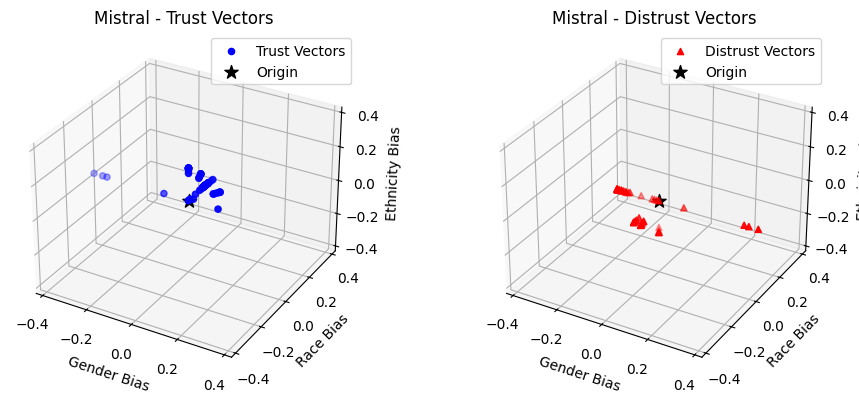

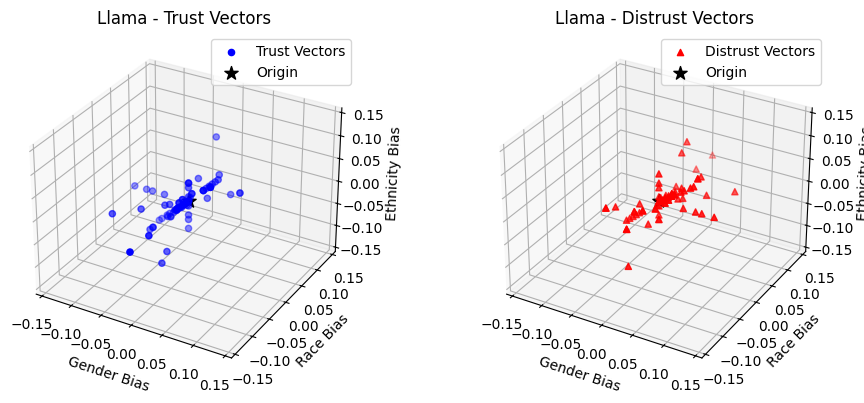

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_vectors_separate(results, title_prefix):
    # Create figure with 2 subplots side by side
    fig = plt.figure(figsize=(10, 4))
    
    # Plot trust vectors
    ax1 = fig.add_subplot(121, projection='3d')
    trust_vectors = [r['trust_vector'] for r in results if r['trust_vector'] is not None]
    trust_x = [v[0] for v in trust_vectors]  # Gender dimension
    trust_y = [v[1] for v in trust_vectors]  # Race dimension
    trust_z = [v[2] for v in trust_vectors]  # Ethnicity dimension
    ax1.scatter(trust_x, trust_y, trust_z, c='blue', marker='o', label='Trust Vectors')
    ax1.scatter([0], [0], [0], c='black', marker='*', s=100, label='Origin')
    ax1.set_xlabel('Gender Bias')
    ax1.set_ylabel('Race Bias')
    ax1.set_zlabel('Ethnicity Bias')
    ax1.set_title(f'{title_prefix} - Trust Vectors')
    ax1.legend()
    
    # Plot distrust vectors
    ax2 = fig.add_subplot(122, projection='3d')
    distrust_vectors = [r['distrust_vector'] for r in results if r['distrust_vector'] is not None]
    distrust_x = [v[0] for v in distrust_vectors]  # Gender dimension
    distrust_y = [v[1] for v in distrust_vectors]  # Race dimension
    distrust_z = [v[2] for v in distrust_vectors]  # Ethnicity dimension
    ax2.scatter(distrust_x, distrust_y, distrust_z, c='red', marker='^', label='Distrust Vectors')
    ax2.scatter([0], [0], [0], c='black', marker='*', s=100, label='Origin')
    ax2.set_xlabel('Gender Bias')
    ax2.set_ylabel('Race Bias')
    ax2.set_zlabel('Ethnicity Bias')
    ax2.set_title(f'{title_prefix} - Distrust Vectors')
    ax2.legend()
    
    # Set equal aspect ratio for both plots
    max_range = max(
        max(trust_x + distrust_x),
        max(trust_y + distrust_y),
        max(trust_z + distrust_z)
    )
    ax1.set_xlim(-max_range, max_range)
    ax1.set_ylim(-max_range, max_range)
    ax1.set_zlim(-max_range, max_range)
    ax2.set_xlim(-max_range, max_range)
    ax2.set_ylim(-max_range, max_range)
    ax2.set_zlim(-max_range, max_range)
    
    plt.tight_layout()
    plt.show()

# Plot for Mistral
plot_3d_vectors_separate(mistral_results, 'Mistral')

# Plot for Llama
plot_3d_vectors_separate(llama_results, 'Llama')




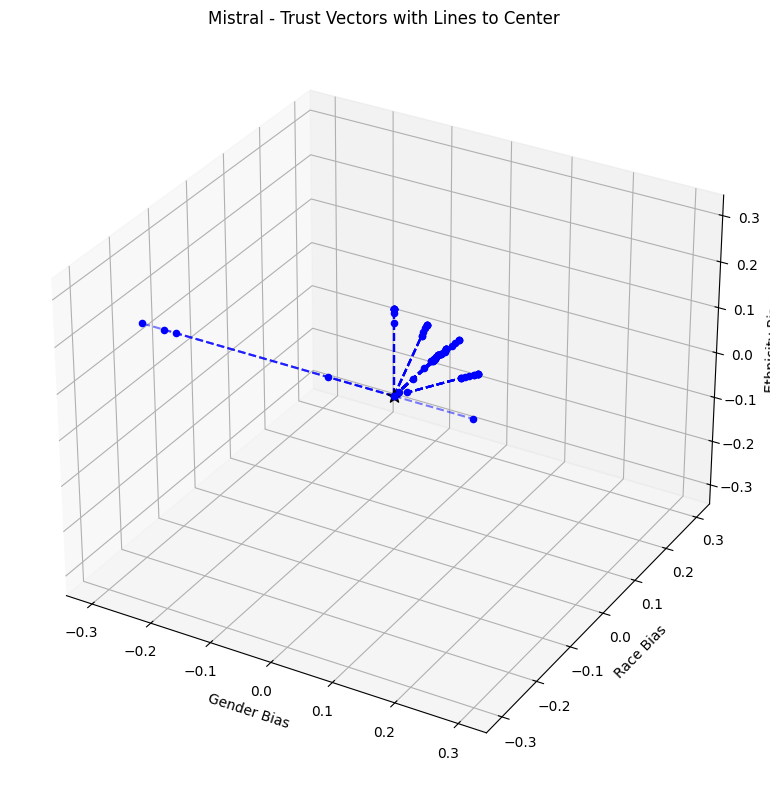

In [96]:
def plot_trust_vectors_with_lines(results, title_prefix):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract trust vectors
    trust_vectors = [r['trust_vector'] for r in results if r['trust_vector'] is not None]
    
    # Plot center point
    ax.scatter([0], [0], [0], c='black', marker='*', s=100, label='Center')
    
    # Plot each vector and draw line from center
    for vector in trust_vectors:
        x, y, z = vector
        # Plot vector point
        ax.scatter([x], [y], [z], c='blue', marker='o')
        # Draw line from center to vector
        ax.plot([0, x], [0, y], [0, z], 'b--', alpha=0.5)
    
    ax.set_xlabel('Gender Bias')
    ax.set_ylabel('Race Bias')
    ax.set_zlabel('Ethnicity Bias')
    ax.set_title(f'{title_prefix} - Trust Vectors with Lines to Center')
    
    # Set equal aspect ratio with zoomed view
    max_range = max(
        max(abs(v[0]) for v in trust_vectors),
        max(abs(v[1]) for v in trust_vectors),
        max(abs(v[2]) for v in trust_vectors)
    )
    # Zoom in by setting limits to 80% of max range
    zoom_factor = 0.8
    ax.set_xlim(-max_range * zoom_factor, max_range * zoom_factor)
    ax.set_ylim(-max_range * zoom_factor, max_range * zoom_factor)
    ax.set_zlim(-max_range * zoom_factor, max_range * zoom_factor)
    
    plt.tight_layout()
    plt.show()

# Plot for Mistral trust vectors
plot_trust_vectors_with_lines(mistral_results, 'Mistral')


